In [ ]:
import csv
from pathlib import Path

import numpy as np

import torch
from torch import nn
import torch.nn.functional as tfunc
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cuda


In [ ]:
def one_hot(n, i):
    q = np.zeros(n)
    q[i] = 1.0
    return q


class MNISTDataset(Dataset):
    def __init__(self, fp):

        xy = np.loadtxt(fp, delimiter=',', dtype=np.float32)

        self.n_samples = xy.shape[0]

        self.x = []
        for i in range(self.n_samples):
            img = xy[i, 1:].reshape((28, 28))
            self.x.append(img)

        self.x = np.array(self.x)
        self.x = torch.from_numpy(self.x)
        self.x = torch.unsqueeze(self.x, 1)
        self.x = self.x / 255.0

        labels = []
        for i in range(self.n_samples):
            labels.append(one_hot(10, int(xy[i, 0])))

        self.y = np.array(labels)
        self.y = torch.from_numpy(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.n_samples

In [ ]:
train_dataset = MNISTDataset(Path('/content/sample_data/mnist_train_small.csv'))
test_dataset = MNISTDataset(Path('/content/sample_data/mnist_test.csv'))

In [ ]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)

In [ ]:
def train(model, optimizer, loss_function, dataloader):
    model.train()

    for (x, y) in dataloader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)

        loss = loss_function(y_pred, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

In [ ]:
def test(model, loss_function, dataloader):
    n = len(dataloader.dataset)
    n_batches = len(dataloader)

    loss = 0
    n_true_positive = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            loss += loss_function(y_pred, y).item()
            n_true_positive += (y_pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    return (loss / n_batches, n_true_positive / n)


In [ ]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.convolution = nn.Sequential(
            nn.Conv2d(1, 4, 21, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 * 4 * 4, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        c = self.convolution(x)
        y = self.classifier(c)
        return y

In [ ]:
n_epoch = 16
learning_rate = 1e-2

In [ ]:
model = ConvolutionalNeuralNetwork().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
print(f'model size: {sum([p.nelement() for p in model.parameters()])}')

model size: 2418


In [ ]:
for i in range(n_epoch):
    train(model, optimizer, loss_function, train_dataloader)
    loss, acc = test(model, loss_function, test_dataloader)
    print(f"Epoch: {i+1:<3}| loss: {round(loss, 3):<6}| accuracy: {round(acc * 100, 4):<6}%")

Epoch: 1  | loss: 1.523 | accuracy: 94.18 %
Epoch: 2  | loss: 1.522 | accuracy: 94.17 %
Epoch: 3  | loss: 1.522 | accuracy: 94.17 %
Epoch: 4  | loss: 1.522 | accuracy: 94.2  %
Epoch: 5  | loss: 1.522 | accuracy: 94.19 %
Epoch: 6  | loss: 1.522 | accuracy: 94.22 %
Epoch: 7  | loss: 1.522 | accuracy: 94.21 %
Epoch: 8  | loss: 1.521 | accuracy: 94.21 %
Epoch: 9  | loss: 1.521 | accuracy: 94.22 %
Epoch: 10 | loss: 1.521 | accuracy: 94.23 %
Epoch: 11 | loss: 1.521 | accuracy: 94.25 %
Epoch: 12 | loss: 1.521 | accuracy: 94.25 %
Epoch: 13 | loss: 1.521 | accuracy: 94.26 %
Epoch: 14 | loss: 1.521 | accuracy: 94.28 %
Epoch: 15 | loss: 1.521 | accuracy: 94.25 %
Epoch: 16 | loss: 1.521 | accuracy: 94.27 %


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
kernels = model.convolution[0]
kernels = kernels.to('cpu')
kernels = list(kernels.parameters())[0]
kernels = torch.squeeze(kernels, 1)
kernels = np.array([k.detach().numpy() for k in kernels])

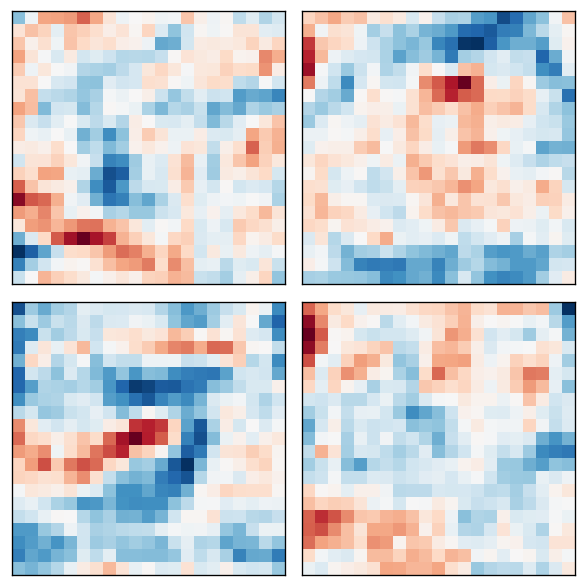

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)

fig.set_figwidth(5)
fig.set_figheight(5)
fig.set_dpi(120)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(kernels[i], cmap='RdBu')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()